In [24]:
using DifferentialEquations
using Distributions
using StatsBase
using LinearAlgebra
using PyPlot; const plt = PyPlot
PyPlot.matplotlib.style.use("./paper.mplstyle");

include("utils.jl")
include("kernels.jl")
include("block_delay_kernel_dde.jl")
include("erlang_superpos_kernel.jl")
include("erlang_block_kernel.jl");

# Kernels

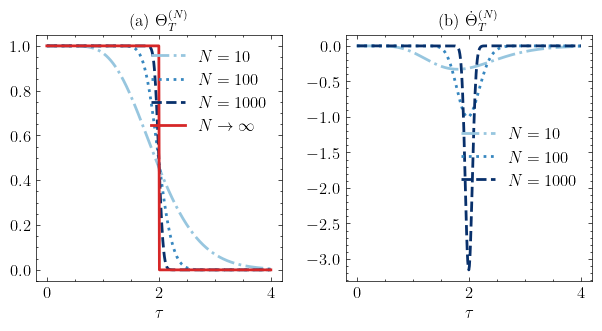

In [2]:
T = 2
τ_range = 0:0.01:2*T
fig, (axl, axr) = plt.subplots(nrows = 1, ncols = 2, figsize = (7.2, 3.2))
axl.plot(
    τ_range, Θ_ker.(τ_range, T, 10),
    label = L"N = 10", color = plt.get_cmap("Blues")(100),
    linestyle = "-."
)
axl.plot(
    τ_range, Θ_ker.(τ_range, T, 100),
    label = L"N = 100", color = plt.get_cmap("Blues")(170),
    linestyle = ":"
)
axl.plot(
    τ_range, Θ_ker.(τ_range, T, 1000),
    label = L"N = 1000", color = plt.get_cmap("Blues")(255),
    linestyle = "--"
)
axl.plot(
    τ_range, Θ.(τ_range, T),
    label = L"N \to \infty", color = "tab:red"
)
axl.legend()

axr.plot(
    τ_range, -Kₘ.(τ_range, T/10, 10)/T,
    label = L"N = 10", color = plt.get_cmap("Blues")(100),
    linestyle = "-."
)
axr.plot(
    τ_range, -Kₘ.(τ_range, T/100, 100)/T,
    label = L"N = 100", color = plt.get_cmap("Blues")(170),
    linestyle = ":"
)
axr.plot(
    τ_range, -Kₘ.(τ_range, T/1000, 1000)/T,
    label = L"N = 1000", color = plt.get_cmap("Blues")(255),
    linestyle = "--"
)
axr.legend()

axl.set(
    xlabel = L"\tau",
    box_aspect = 1,
    title = L"\text{(a) }\Theta_T^{(N)}"
)
axr.set(
    box_aspect = 1,
    xlabel = L"\tau",
    title = L"\text{(b) }\dot{\Theta}_T^{(N)}"
    # title = L"\text{(b) }\mathrm{d}\Theta_T^{(N)} / \mathrm{d}\tau"
)
display(fig)

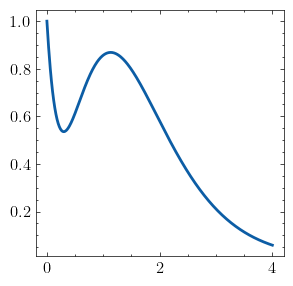

In [119]:
fig, ax = plt.subplots()
T = 2; N = 4
f(τ) = (Kₘ(τ, T/N, 1) - Kₘ(τ, T/N, 2) + 3 * Kₘ(τ, T/N, 3) + 1 * Kₘ(τ, T/N, 4)) * T / N
x = 0:0.01:2*T
ax.plot(x, f(x))
display(fig)

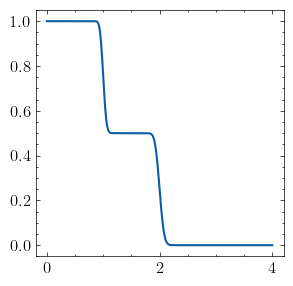

In [184]:
c(m) = m <= N/2 ? 1 : 0.5

fig, ax = plt.subplots()
T = 2; N = 1000
f(τ) = T / N * sum([c(m) * Kₘ(τ, T/N, m) for m in 1:N])
x = 0:0.01:4
ax.plot(x, f(x))
display(fig)

# SIRS time delay system with step function block delay kernel (Hethcote et al. 1981)

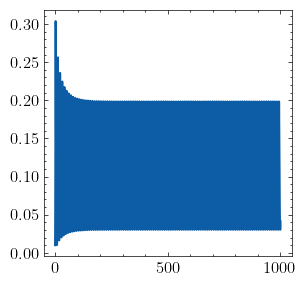

0.305244771656034
0.4926388580566674


In [3]:
p = (β, ρ, T) = (3, 1, 6)
I₀ = 0.01
t_max = 1000
sol = solve_step_function_kernel(p..., I₀, t_max)

println(pearson_skew(sol, 1, 200, t_max))
println(skew(sol, 1, 200, t_max))

fig, ax = plt.subplots()
# ax.set(xlim=(0, 200))
ax.plot(sol.t, sol[1, :])
# ax.plot(sol.t, sol[2, :])
display(fig)

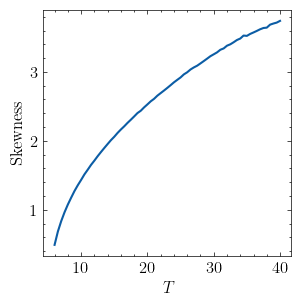

In [19]:
β, ρ = 3, 1
I₀ = 0.01
t_trans = 200; t_max = 5000

# X
Ts = 6:0.5:40
# Y
skews = [skew(solve_step_function_kernel(β, ρ, T, I₀, t_max), 1, t_trans, t_max) for T in Ts]

fig, ax = plt.subplots()
ax.set(xlabel = L"T", ylabel = "Skewness")
ax.plot(Ts, skews)
display(fig)

# Block delay kernel as Erlang Kernel sum

The dwell-time of individuals in the recovered compartment R is given by a block
kernel. With that the recovered compartment is given as a superposition
$$
    R = \sum_m R_m
$$

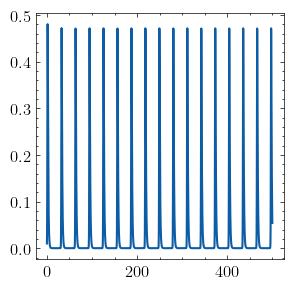

0.35014996610479343
3.323262587786563


In [20]:
p = (β, ρ, T, N) = (5, 1, 24, 150)
I₀ = 0.01
t_max = 500
sol = solve_erlang_block_kernel(β, ρ, T, N, I₀, t_max)

println(pearson_skew(sol, 1, 200, t_max))
println(skew(sol, 1, 200, t_max))

fig, ax = plt.subplots()
# ax.set(xlim=(0, 200))
ax.plot(sol.t, sol[1, :])
# ax.plot(sol.t, erlang_sum_kernel_R(sol))
display(fig)

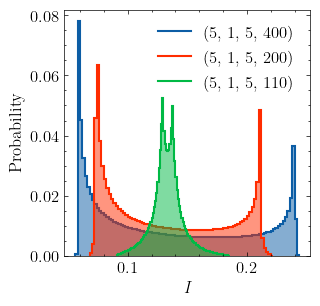

In [6]:
# parameters (β, ρ, T, N)
parameter_sets = [(5, 1, 5, 400), (5, 1, 5, 200), (5, 1, 5, 110)]
I₀ = 0.01
t_max = 2000; t_trans = 200

fig, ax = plt.subplots()
for p in parameter_sets
    sol = solve_erlang_block_kernel(p..., I₀, t_max)
    # print(p)
    # print("Skewness ", skew(sol, 1, t_trans, t_max))
    # print("Pearson ", pearson_skew(sol, 1, t_trans, t_max))
    hist = normalized_sol_hist(sol, 1, t_trans, t_max)
    ax.set(xlabel = L"I", ylabel = "Probability", box_aspect = 1)
    ax.stairs(hist.weights, hist.edges[1], label = repr(p))
    ax.fill_between(hist.edges[1][1:end-1], hist.weights, alpha = 0.5, step = "post")
end
ax.legend()
display(fig)

In [11]:
function generate_skew_convergence(
        β::Real, ρ::Real, T::Real, N_max::Integer, t_trans::Real, t_max::Real;
        ΔN::Integer = 1, I₀ = 0.01
    )
    p = (β, ρ, T)
    Ns = erlang_block_kernel_oscillation_onset(p...; N_max = N_max):ΔN:N_max
    skews = [skew(solve_erlang_block_kernel(p..., N, I₀, t_max), 1, t_trans, t_max) for N in Ns]
    return Ns, skews
end;

In [21]:
p = (β, ρ, T) = (3, 1, 20)
t_trans = 200; t_max = 2000
# Reference value -- step function kernel (sfk)
skew_sfk = skew(solve_step_function_kernel(p..., I₀, t_max), 1, t_trans, t_max)
# Increasingly sharp erlang sum kernels (esk)
Ns, skews_esk = generate_skew_convergence(p..., 1000, t_trans, t_max; ΔN = 3);

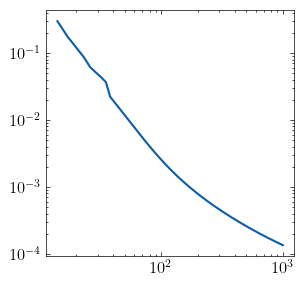

In [13]:
fig, ax = plt.subplots()
ax.set(xscale = "log", yscale = "log")
# (skew_sfk .- skews_esk)/skew_sfk
ax.plot(Ns, (skew_sfk .- skews_esk)/skew_sfk)
display(fig)

## Eigenvalues

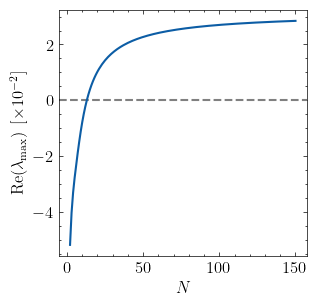

In [27]:
Ns = 2:150
p = (β, ρ, T) = (3, 1, 20)

fig, ax = plt.subplots()
ax.set(
    xlabel = L"N", ylabel = L"\operatorname{Re}(\lambda_\mathrm{max}) \: \left[\times 10^{-2}\right]"
)
ax.axhline(0.0, ls = "--", c = "gray")
# ax.plot(Ns, map(N -> _λ_max(p..., N), Ns) ./ 10^(-2))
ax.plot(Ns, λ_max.(erlang_block_kernel_jacobian.(p..., Ns)) ./ 10^(-2))
display(fig)

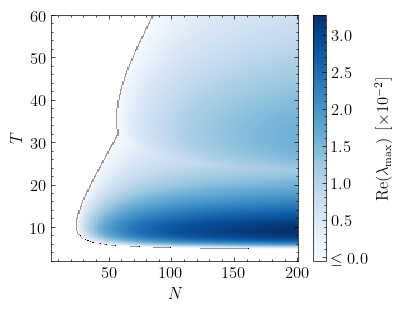

sys:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


In [28]:
Ns = 5:1:200
Ts = 2:0.1:60
β, ρ = 5, 1

# https://groups.google.com/g/julia-users/c/83Pfg9HGhGQ/m/9G_0wi-GBQAJ
z = [λ_max(erlang_block_kernel_jacobian(β, ρ, T, N)) for T in Ts, N in Ns]
sign_change = (diff(sign.(z), dims = 1) .!= 0)[:, 1:end-1] + (diff(sign.(z), dims = 2) .!= 0)[1:end-1, :]

fig, ax = plt.subplots(figsize = (4, 3.2))
ax.set(box_aspect = 1, xlabel = L"N", ylabel = L"T")
# Heatmap
hm_cmap = plt.cm.Blues.copy()
hm_cmap.set_under("white")
z_scaled = z ./ 10^(-2)
hm = ax.pcolormesh(Ns, Ts, z_scaled,
                   cmap = hm_cmap, vmin = 0)
# Colorbar
cbar = plt.colorbar(hm)
cbar.ax.set(ylim = (-(maximum(z_scaled) - minimum(z_scaled))/1000, maximum(z_scaled)))
cbar_labels = [label.get_text() for label in cbar.ax.get_yticklabels()]
cbar_labels[2] = L"\leq 0.0"
cbar.ax.set_yticklabels(cbar_labels)
cbar.set_label(L"\operatorname{Re}(\lambda_\mathrm{max}) \: \left[\times 10^{-2}\right]", rotation=90)
# Border -- TODO
border_cmap = plt.cm.Greys.copy()
border_cmap.set_under(alpha = 0)
ax.pcolormesh(Ns, Ts, sign_change, cmap=border_cmap, vmin = 10^(-10))
display(fig)

# Two step block delay

In [176]:
function erlang_superpos_kernel!(du, u, p, t)
    β, ρ, T, N, cₘ = p
    # c(m) = m <= N/2 ? 1 : 0.5
    R = sum([cₘ(m-1) * u[m] for m in 2:N+1])
    du[1] = β * u[1] * (1 - u[1] - R) - ρ * u[1]
    du[2] = ρ * u[1] - (N/T) * u[2]
    for m in 3:N+1
        du[m] = N * (u[m-1] - u[m]) / T
    end
end

function solve_erlang_superpos_kernel(
        β::Real, ρ::Real, T::Real,
        N::Integer, cₘ::Function,
        I₀::Real, t_max::Real
    )
    p = (β, ρ, T, N, cₘ)
    u₀ = zeros(N+1); u₀[1] = I₀
    sol = solve(
        ODEProblem(erlang_superpos_kernel!, u₀, (0.0, t_max), p),
        RK4(),
        # alg_hints = [:stiff],
        reltol = 1e-8
    )
    return sol
end

function erlang_superpos_kernel_jacobian(
        β::Real, ρ::Real, T::Real,
        N::Integer, cₘ::Function,
        I_endemic::Real
    )
    dim::Integer = N + 1
    Rₘ_endemic::Real = T * ρ * I_endemic / N
    R_endemic::Real = sum([cₘ(m) * Rₘ_endemic for m in 1:N])
    jac::Matrix{Float64} = diagm(0 => fill(-N/T, dim), -1 => fill(N/T, dim-1))
    jac[1, 1] = β * (1 - 2 * I_endemic - R_endemic) - ρ
    jac[1, 2:end] = [-β * I_endemic * cₘ(m) for m in 1:N]
    jac[2, 1] = ρ
    return jac
end

# FP for system with c(m) = m <= N_mid ? k₁ : k₂
general_two_step_kernel_fp(β, ρ, T, N, N_mid, k₁, k₂) = N * (β - ρ) / (β * (N * T * k₂ * ρ + N + N_mid * T * k₁ * ρ - N_mid * T * k₂ * ρ))

general_two_step_kernel_fp (generic function with 1 method)

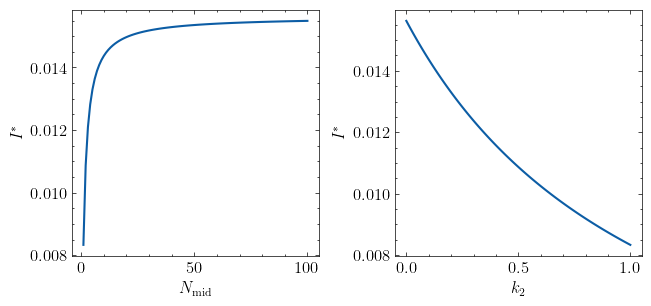

In [165]:
p = (β, ρ, T, N) = (0.8, 0.7, 20, 300)
fig, (axl, axr) = plt.subplots(figsize = (7.5, 3.2), ncols = 2)
k₁, k₂ = 1, 0.5
N_mids = [N/i for i in 1:100]
axl.set(xlabel = L"N_\mathrm{mid}", ylabel = L"I^*", box_aspect=1)
axl.plot(1:100, general_two_step_kernel_fp.(p..., N_mids, k₁, k₂))

p = (β, ρ, T, N) = (0.8, 0.7, 20, 300)
N_mid, k₁ = N/2, 1
k₂s = 0:0.01:1
axr.set(xlabel = L"k_2", ylabel = L"I^*", box_aspect=1)
axr.plot(k₂s, general_two_step_kernel_fp.(p..., N_mid, k₁, k₂s))
display(fig)

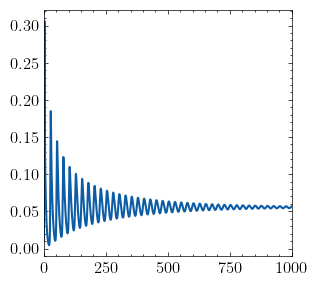

sol[1, end] = 0.05663512802366258
general_two_step_kernel_fp(p..., N_mid, k₁, k₂) = 0.05555555555555555


In [180]:
p = (β, ρ, T, N) = (3, 1, 20, 300)
N_mid, k₁, k₂ = N/10, 1, 0.5
c(m) = m <= N_mid ? k₁ : k₂
I₀ = 0.01
t_max = 1000
sol = solve_erlang_superpos_kernel(p..., c, I₀, t_max)

fig, ax = plt.subplots()
ax.set(xlim=(0, 1000))
ax.plot(sol.t, sol[1, :])
# ax.plot(sol.t, erlang_sum_kernel_R(sol))
display(fig)
@show sol[1, end]
@show general_two_step_kernel_fp(p..., N_mid, k₁, k₂);